# Diabetic-IA

Este projeto é com fim didático para a disciplina de Inteligência Artificial ministrada pelo professor e mestre Sandro Moreira, na qual eu estou como aluno observador nas aulas do curso de engenharia de software.

O projeto consiste em criar um modelo de IA que prevê se um paciente tem diabetes ou não, dado um conjunto de dados. É obrigatório o uso do algoritmo supervisionado regressão de múltiplas classes ou classificatória.

## Importação das dependências e configuração do projeto

### Importação das dependências

In [625]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import nbformat
import optuna
import joblib


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay

In [531]:
!nvidia-smi

Sun Mar  2 23:01:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.10              Driver Version: 570.86.10      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   58C    P8              6W /   80W |      61MiB /   6144MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Carregamento dos dados

In [532]:
df_diabetes = pd.read_csv('../datasets/diabetes_prediction_dataset.csv')

## Preparação dos dados

### Ajustando os dados

In [533]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [534]:
df_diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [535]:
# Detectando valores nulos

df_diabetes.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

#### Análise dos dados

Aqui percebe-se que: 

- não temos registros nulos.
- alguns nomes das colunas precisam ser ajustados, sempre mantendo um nome semântico e todo em lowercase com underlines.
- temos algumas colunas em formatos errados ou que podem ser transformados para outro tipo, como a idade e gênero, que podem ser convertidos para inteiros.
- a coluna smoking_history precisa conter dois valores, current e never, o no info deve ser substituído mais pra fente.

#### Renomeando colunas

In [536]:
df_diabetes.columns = [
  'gender',
  'age',
  'hypertension',
  'heart_disease',
  'smoker',
  'bmi',
  'hba1c_level',
  'blood_glucose_level',
  'diabetic',
]

#### Duplicando o DataFrame para Análise Exploratória

In [537]:
# Copiando para análise exploratória
df_diabetes_eda = df_diabetes.copy()

#### Visualizando os dados

In [538]:
df_diabetes_eda.head(20)

,gender,age,hypertension,heart_disease,smoker,bmi,hba1c_level,blood_glucose_level,diabetic
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


#### Análise dos dados

Podemos observar agora que a coluna "smoker" tem mais do que 2 possibilidades, então precisamos visualizar os possíveis tipos de valores nessas variáveis categóricas para termos certeza que não vamos deixar passar alguma informação que seja fora da realidade ou equívoca.

In [539]:
df_diabetes_eda.gender.unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [540]:
df_diabetes_eda.smoker.unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [541]:
df_diabetes_eda.hypertension.unique()


array([0, 1])

In [542]:
df_diabetes_eda.heart_disease.unique()

array([1, 0])

In [543]:
df_diabetes_eda.diabetic.unique()

array([0, 1])

Podemos ver que a variável "smoker" é de fato categórica e ordinal, ou seja, a ordem dos dados importa. Logo, podemos presumir que há uma hierarquia nessa ordem:

1. current (fumante atual)
2. ever (já fumou)
3. not current (não fuma atualmente)
4. former (ex-fumante)
5. never (nunca fumou)

Devemos ajustar os valores da variável "smoker" sobre os valores "ever", "not current" e "former", pois isso deu uma ambiguidade pois se trata de pessoas que não fumam atualmente mas já fumaram. No caso de "not current", a pessoa pode tanto incluir ex-fumantes (former) quanto quem nunca fumou (never).

Logo, podemos fazer uma distribuíção do valor "former" para "ever", e também distribuir o "not-current" entre os valores "former".

Sobre a variável "gender", podemos converter para "F" os valores "Female" e "M" para os "Male", e também distribuir "M" e "F" para o valor "Other", já que biologicamente só existem 2 gêneros, ou remover os registros.

Podemos observar também que não há outros valores além de 0 e 1 em "hypertension", "heart_disease" e "diabetic".


### Tratamento pós análise

#### Fumantes

In [544]:
#Verificando a quantidade de cada tipo de fumante 

df_diabetes_eda.smoker.value_counts()

smoker
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [545]:
# Substituindo os valores "ever" para "former"

df_diabetes_eda.smoker = df_diabetes_eda.smoker.replace('ever', 'former')
df_diabetes.smoker = df_diabetes.smoker.replace('ever', 'former')

In [546]:
# Substituindo os valores "not current" para "former"

df_diabetes_eda.smoker = df_diabetes_eda.smoker.replace('not current', 'former')
df_diabetes.smoker = df_diabetes.smoker.replace('not current', 'former')

In [547]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoker               100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   hba1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetic             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [548]:
df_diabetes_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoker               100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   hba1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetic             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [549]:
# Removendo os valores "No Info"

df_diabetes_eda = df_diabetes_eda[df_diabetes_eda['smoker'] != 'No Info']
df_diabetes = df_diabetes[df_diabetes['smoker'] != 'No Info']

#### Gênero

In [550]:
# Removendo os registros com "Other"

df_diabetes_eda = df_diabetes_eda[df_diabetes_eda['gender'] != 'Other']
df_diabetes = df_diabetes[df_diabetes['gender'] != 'Other']

#### Convertendo os tipos das variáveis

In [551]:
df_diabetes_eda.age = df_diabetes_eda.age.astype(int)
df_diabetes.age = df_diabetes.age.astype(int)

In [552]:
df_diabetes_eda.gender = df_diabetes_eda.gender.replace('Female', '0')
df_diabetes_eda.gender = df_diabetes_eda.gender.replace('Male', '1')

df_diabetes.gender = df_diabetes.gender.replace('Female', '0')
df_diabetes.gender = df_diabetes.gender.replace('Male', '1')

In [553]:
df_diabetes_eda.gender.value_counts()

gender
0    38852
1    25320
Name: count, dtype: int64

In [554]:
df_diabetes_eda.gender = df_diabetes_eda.gender.astype(int)
df_diabetes.gender = df_diabetes.gender.astype(int)

In [555]:
df_diabetes_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64172 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               64172 non-null  int64  
 1   age                  64172 non-null  int64  
 2   hypertension         64172 non-null  int64  
 3   heart_disease        64172 non-null  int64  
 4   smoker               64172 non-null  object 
 5   bmi                  64172 non-null  float64
 6   hba1c_level          64172 non-null  float64
 7   blood_glucose_level  64172 non-null  int64  
 8   diabetic             64172 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 4.9+ MB


### Cuidando de Outliers

#### Visualizando os dados

In [556]:
df_diabetes_eda.head(20)

,gender,age,hypertension,heart_disease,smoker,bmi,hba1c_level,blood_glucose_level,diabetic
0,0,80,0,1,never,25.19,6.6,140,0
2,1,28,0,0,never,27.32,5.7,158,0
3,0,36,0,0,current,23.45,5.0,155,0
4,1,76,1,1,current,20.14,4.8,155,0
5,0,20,0,0,never,27.32,6.6,85,0
6,0,44,0,0,never,19.31,6.5,200,1
8,1,42,0,0,never,33.64,4.8,145,0
9,0,32,0,0,never,27.32,5.0,100,0
10,0,53,0,0,never,27.32,6.1,85,0
11,0,54,0,0,former,54.70,6.0,100,0


In [557]:
df_diabetes_eda.describe()

,gender,age,hypertension,heart_disease,bmi,hba1c_level,blood_glucose_level,diabetic
count,64172.000000,64172.000000,64172.000000,64172.000000,64172.000000,64172.000000,64172.000000,64172.000000
mean,0.394565,46.546001,0.097909,0.047045,28.424262,5.564279,139.629792,0.109799
std,0.488761,19.542648,0.297194,0.211738,6.515975,1.095535,42.166693,0.312641
min,0.000000,0.000000,0.000000,0.000000,10.080000,3.500000,80.000000,0.000000
25%,0.000000,31.000000,0.000000,0.000000,24.600000,4.800000,100.000000,0.000000
50%,0.000000,47.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,31.100000,6.200000,159.000000,0.000000
max,1.000000,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,1.000000


Podemos observar que há outliers sim (óbvio).

Em "age" focando nas idades menores.

Em "bmi" deve-se atentar aos valores extremos (menos e maiores).

Em "blood_glucose_level", atentar-se a valores muito grandes.

#### Verificando a idade (age)

<Axes: xlabel='age'>

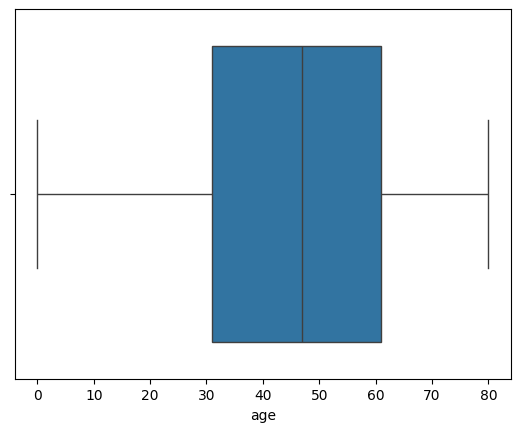

In [558]:
sns.boxplot(x='age', data=df_diabetes_eda)

Observando o mínimo, podemos ver que há registros de pessoas no dataset, podem ser casos raros, então vamos verificar quantos registros com pessoas de idades menores.

<Axes: xlabel='age', ylabel='Count'>

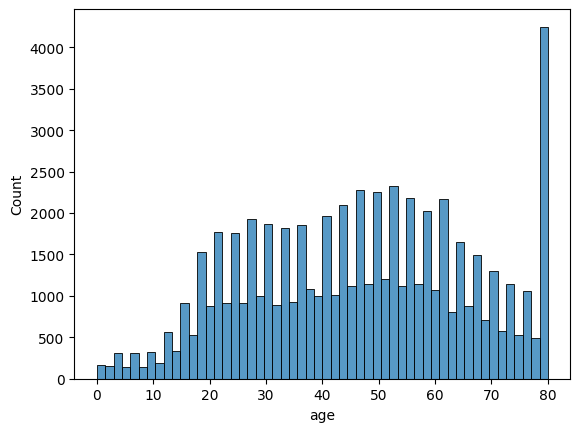

In [559]:
sns.histplot(df_diabetes_eda.age)

In [560]:
# Verifique os valores únicos de age e suas contagens
age_counts = df_diabetes_eda['age'].value_counts().sort_index()

# Encontre o age com a maior contagem
max_age = age_counts.idxmax()
max_count = age_counts.max()

print(f"O age que está extrapolando é: {max_age}")
print(f"Com uma contagem de: {max_count}")

O age que está extrapolando é: 80
Com uma contagem de: 3822


Por volta dos 16 anos para menos, podem ser configurados outliers, mas vamos manter os dados assim e prolongar essa análise sobre a idade, porque até que possui uma quantidade legal de registros.

E também a grande quantidade de pessoa com 80 anos é um tanto quanto estranho. Sabendo disso, podemos tentar aleatorizar o age dessas pessoas em um range de 2 unidades.

In [561]:
# Identificando os índices onde age é igual a 80
index_80 = df_diabetes_eda[df_diabetes_eda['age'] == 80].index

# Gerando valores aleatórios dentro do intervalo desejado
random_values = np.random.randint(-2, 2, len(index_80))

# Adicionando os valores aleatórios ao age original
df_diabetes_eda.loc[index_80, 'age'] = 80 + random_values
df_diabetes.loc[index_80, 'age'] = 80 + random_values

In [562]:
# Verificando as alterações
df_diabetes_eda.loc[index_80, 'age'].head()

0      78
79     80
104    80
107    80
135    80
Name: age, dtype: int64

<Axes: xlabel='age', ylabel='Count'>

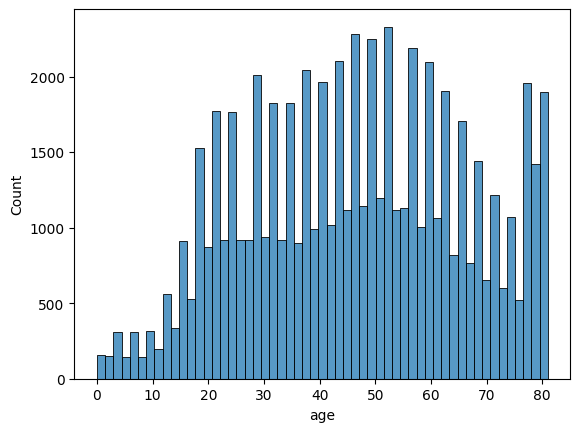

In [563]:
sns.histplot(data=df_diabetes_eda, x='age')

#### Verificando o IMC (bmi)

<Axes: xlabel='bmi'>

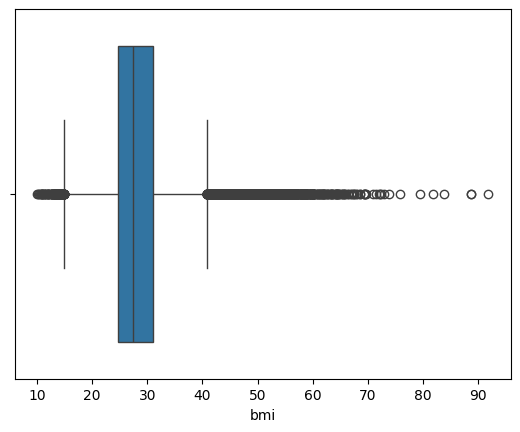

In [564]:
sns.boxplot(x='bmi', data=df_diabetes_eda)

<Axes: xlabel='bmi', ylabel='Count'>

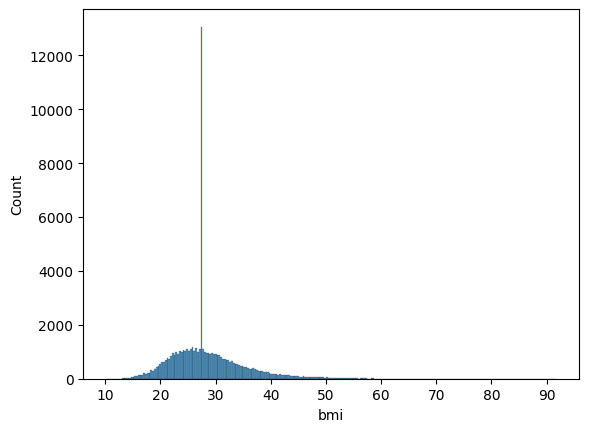

In [565]:
sns.histplot(df_diabetes_eda.bmi)


Como podemos observar, há registros de pessoas com BMI superiores a 50, pode ser que ao inputar os dados, foi de forma equivocada. Sendo assim vamos remover esses registros.

E também há uma quantidade enorme dentro de um grupo e precisamos descobrir qual é o valor.

In [566]:
# Verifique os valores únicos de BMI e suas contagens
bmi_counts = df_diabetes_eda['bmi'].value_counts().sort_index()

# Encontre o BMI com a maior contagem
max_bmi = bmi_counts.idxmax()
max_count = bmi_counts.max()

print(f"O BMI que está extrapolando é: {max_bmi}")
print(f"Com uma contagem de: {max_count}")

O BMI que está extrapolando é: 27.32
Com uma contagem de: 12045


Sabendo disso, podemos tentar aleatorizar o bmi dessas pessoas em um range de 2 unidades.

In [567]:
# Identificando os índices onde BMI é igual a 27.32
index_27_32 = df_diabetes_eda[df_diabetes_eda['bmi'] == 27.32].index

# Gerando valores aleatórios dentro do intervalo desejado
random_values = np.random.uniform(-2, 2, len(index_27_32))

# Adicionando os valores aleatórios ao BMI original
new_bmi_values = 27.32 + random_values

# Arredondando os valores para 2 casas decimais
new_bmi_values = np.round(new_bmi_values, 2)

# Atualizando os valores no DataFrame
df_diabetes_eda.loc[index_27_32, 'bmi'] = new_bmi_values
df_diabetes.loc[index_27_32, 'bmi'] = new_bmi_values

# Verificando as alterações
print(df_diabetes_eda.loc[index_27_32, 'bmi'].head())

2     26.66
5     27.43
9     25.97
10    28.84
26    29.03
Name: bmi, dtype: float64


In [568]:
# Verificando as alterações
df_diabetes_eda.loc[index_27_32, 'bmi'].head()

2     26.66
5     27.43
9     25.97
10    28.84
26    29.03
Name: bmi, dtype: float64

<Axes: xlabel='bmi', ylabel='Count'>

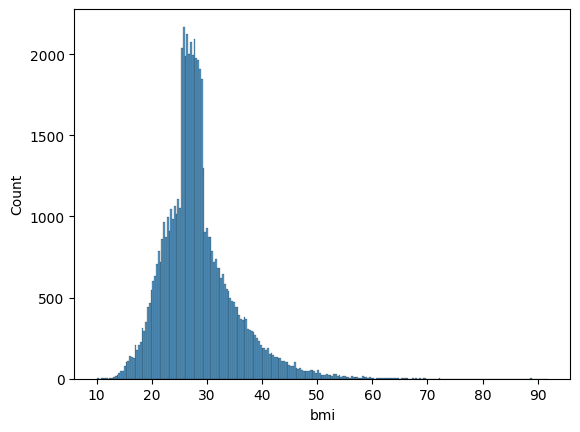

In [569]:
sns.histplot(data=df_diabetes_eda, x='bmi')

In [570]:
# Verificando quantos registros acima de 50 bmi

df_diabetes_eda[df_diabetes_eda['bmi'] > 50].bmi.count()

np.int64(609)

In [571]:
# Removendo os registros com bmi acima de 50

df_diabetes_eda.drop(df_diabetes_eda[df_diabetes_eda['bmi'] > 50].index, axis=0, inplace=True)
df_diabetes.drop(df_diabetes[df_diabetes['bmi'] > 50].index, axis=0, inplace=True)

<Axes: xlabel='bmi'>

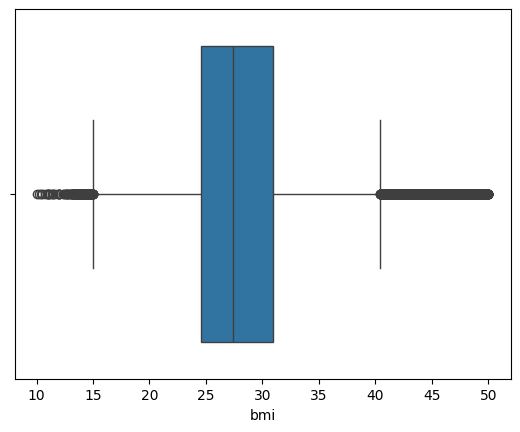

In [572]:
sns.boxplot(x='bmi', data=df_diabetes_eda)

Esses outros registros fora dos limites do boxplot, vamos manter pois pode ser valores reais dentro do público que estamos analisando.

#### Verificando o nível de hbA1c (hba1c_level)

<Axes: xlabel='hba1c_level'>

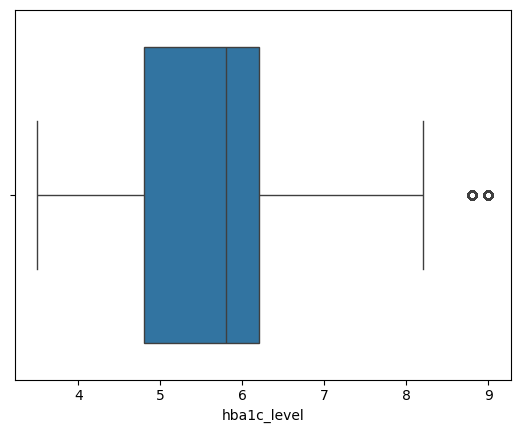

In [573]:
sns.boxplot(x='hba1c_level', data=df_diabetes_eda)

<Axes: xlabel='hba1c_level', ylabel='Count'>

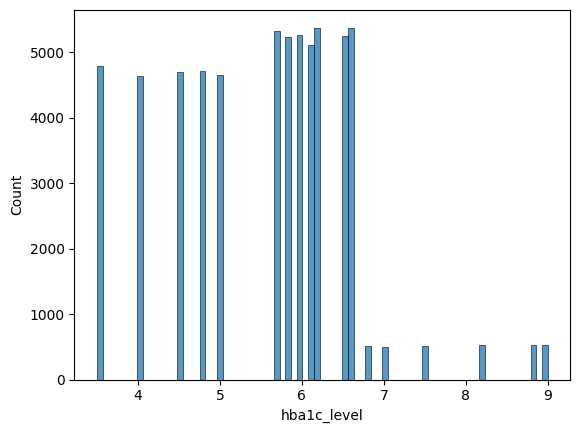

In [574]:
sns.histplot(df_diabetes_eda.hba1c_level)

Assim como o IMC, vamos manter esses valores que ultrapassam o limite, pois podem ser casos dentro da realidade analisada.

#### Verificando o nível de glicose no sangue (blood_glucose_level)

<Axes: xlabel='blood_glucose_level'>

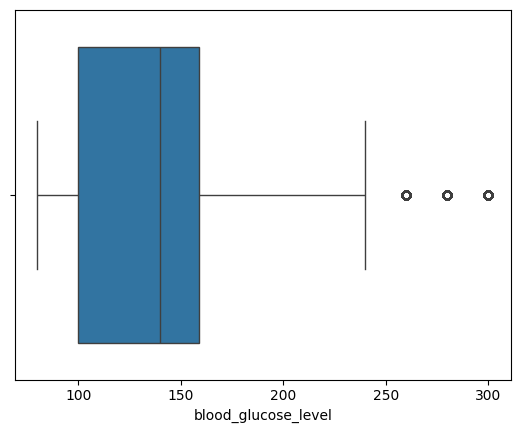

In [575]:
sns.boxplot(x='blood_glucose_level', data=df_diabetes_eda)

<Axes: xlabel='blood_glucose_level', ylabel='Count'>

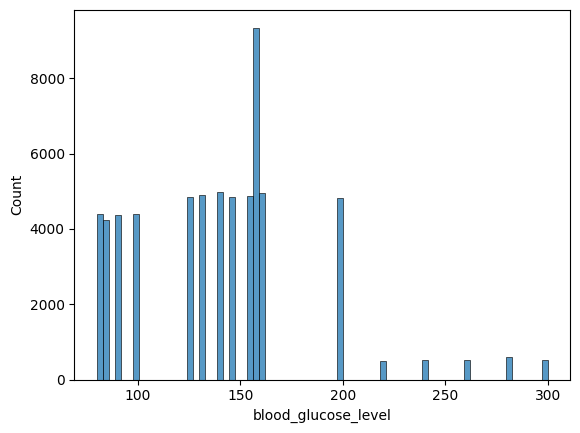

In [576]:
sns.histplot(df_diabetes_eda.blood_glucose_level)

Assim como o IMC, vamos manter esses valores que ultrapassam o limite, pois podem ser casos dentro da realidade analisada.

Mas há um valor com uma quantidade enorme, vamos realizar o mesmo processo feito em age e bmi.

In [577]:
# Verifique os valores únicos de blood_glucose_level e suas contagens
blood_glucose_level_counts = df_diabetes_eda['blood_glucose_level'].value_counts().sort_index()

# Encontre o blood_glucose_level com a maior contagem
max_blood_glucose_level = blood_glucose_level_counts.idxmax()
max_count = blood_glucose_level_counts.max()

print(f"O blood_glucose_level que está extrapolando é: {max_blood_glucose_level}")
print(f"Com uma contagem de: {max_count}")

O blood_glucose_level que está extrapolando é: 140
Com uma contagem de: 4977


In [578]:
# Identificando os índices onde blood_glucose_level é igual a 140
index_140 = df_diabetes_eda[df_diabetes_eda['blood_glucose_level'] == 140].index

# Gerando valores aleatórios dentro do intervalo desejado
random_values = np.random.randint(-5, 5, len(index_140))

# Adicionando os valores aleatórios ao blood_glucose_level original
df_diabetes_eda.loc[index_140, 'blood_glucose_level'] = 140 + random_values
df_diabetes.loc[index_140, 'blood_glucose_level'] = 140 + random_values

In [579]:
# Verificando as alterações
df_diabetes_eda.loc[index_140, 'blood_glucose_level'].head()

0      140
61     136
107    143
114    140
152    137
Name: blood_glucose_level, dtype: int64

<Axes: xlabel='blood_glucose_level', ylabel='Count'>

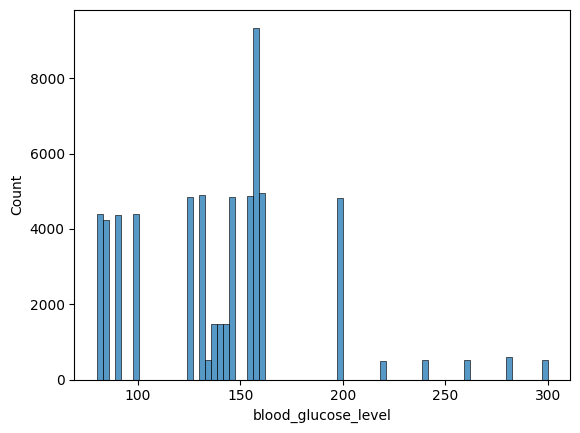

In [580]:
sns.histplot(df_diabetes_eda.blood_glucose_level)

In [581]:
# Verifique os valores únicos de blood_glucose_level e suas contagens
blood_glucose_level_counts = df_diabetes_eda['blood_glucose_level'].value_counts().sort_index()

# Encontre o blood_glucose_level com a maior contagem
max_blood_glucose_level = blood_glucose_level_counts.idxmax()
max_count = blood_glucose_level_counts.max()

print(f"O blood_glucose_level que está extrapolando é: {max_blood_glucose_level}")
print(f"Com uma contagem de: {max_count}")

O blood_glucose_level que está extrapolando é: 160
Com uma contagem de: 4943


In [582]:
# Identificando os índices onde blood_glucose_level é igual a 160
index_160 = df_diabetes_eda[df_diabetes_eda['blood_glucose_level'] == 160].index

# Gerando valores aleatórios dentro do intervalo desejado
random_values = np.random.randint(-5, 5, len(index_160))

# Adicionando os valores aleatórios ao blood_glucose_level original
df_diabetes_eda.loc[index_160, 'blood_glucose_level'] = 160 + random_values
df_diabetes.loc[index_160, 'blood_glucose_level'] = 160 + random_values

<Axes: xlabel='blood_glucose_level', ylabel='Count'>

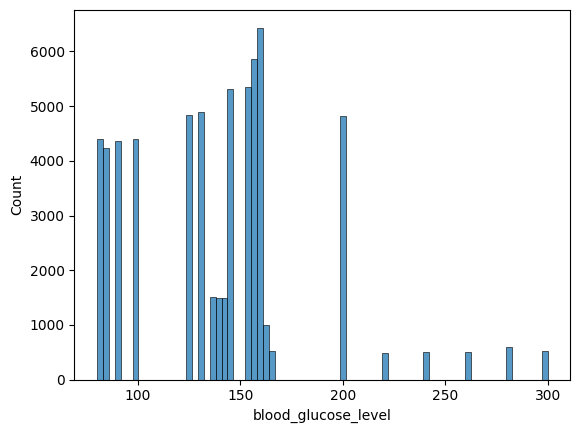

In [583]:
sns.histplot(df_diabetes_eda.blood_glucose_level)

Ok, chegamos num valor razoavel.

### Distribuição do Target

In [584]:
px.bar(df_diabetes_eda.value_counts('diabetic') / len(df_diabetes_eda), title='Diabetic Count')

Observa-se que esse dataset não está nada equilibrado. Logo, nem adianta muito fazer uma análise bivariada.

### Fazendo correlação

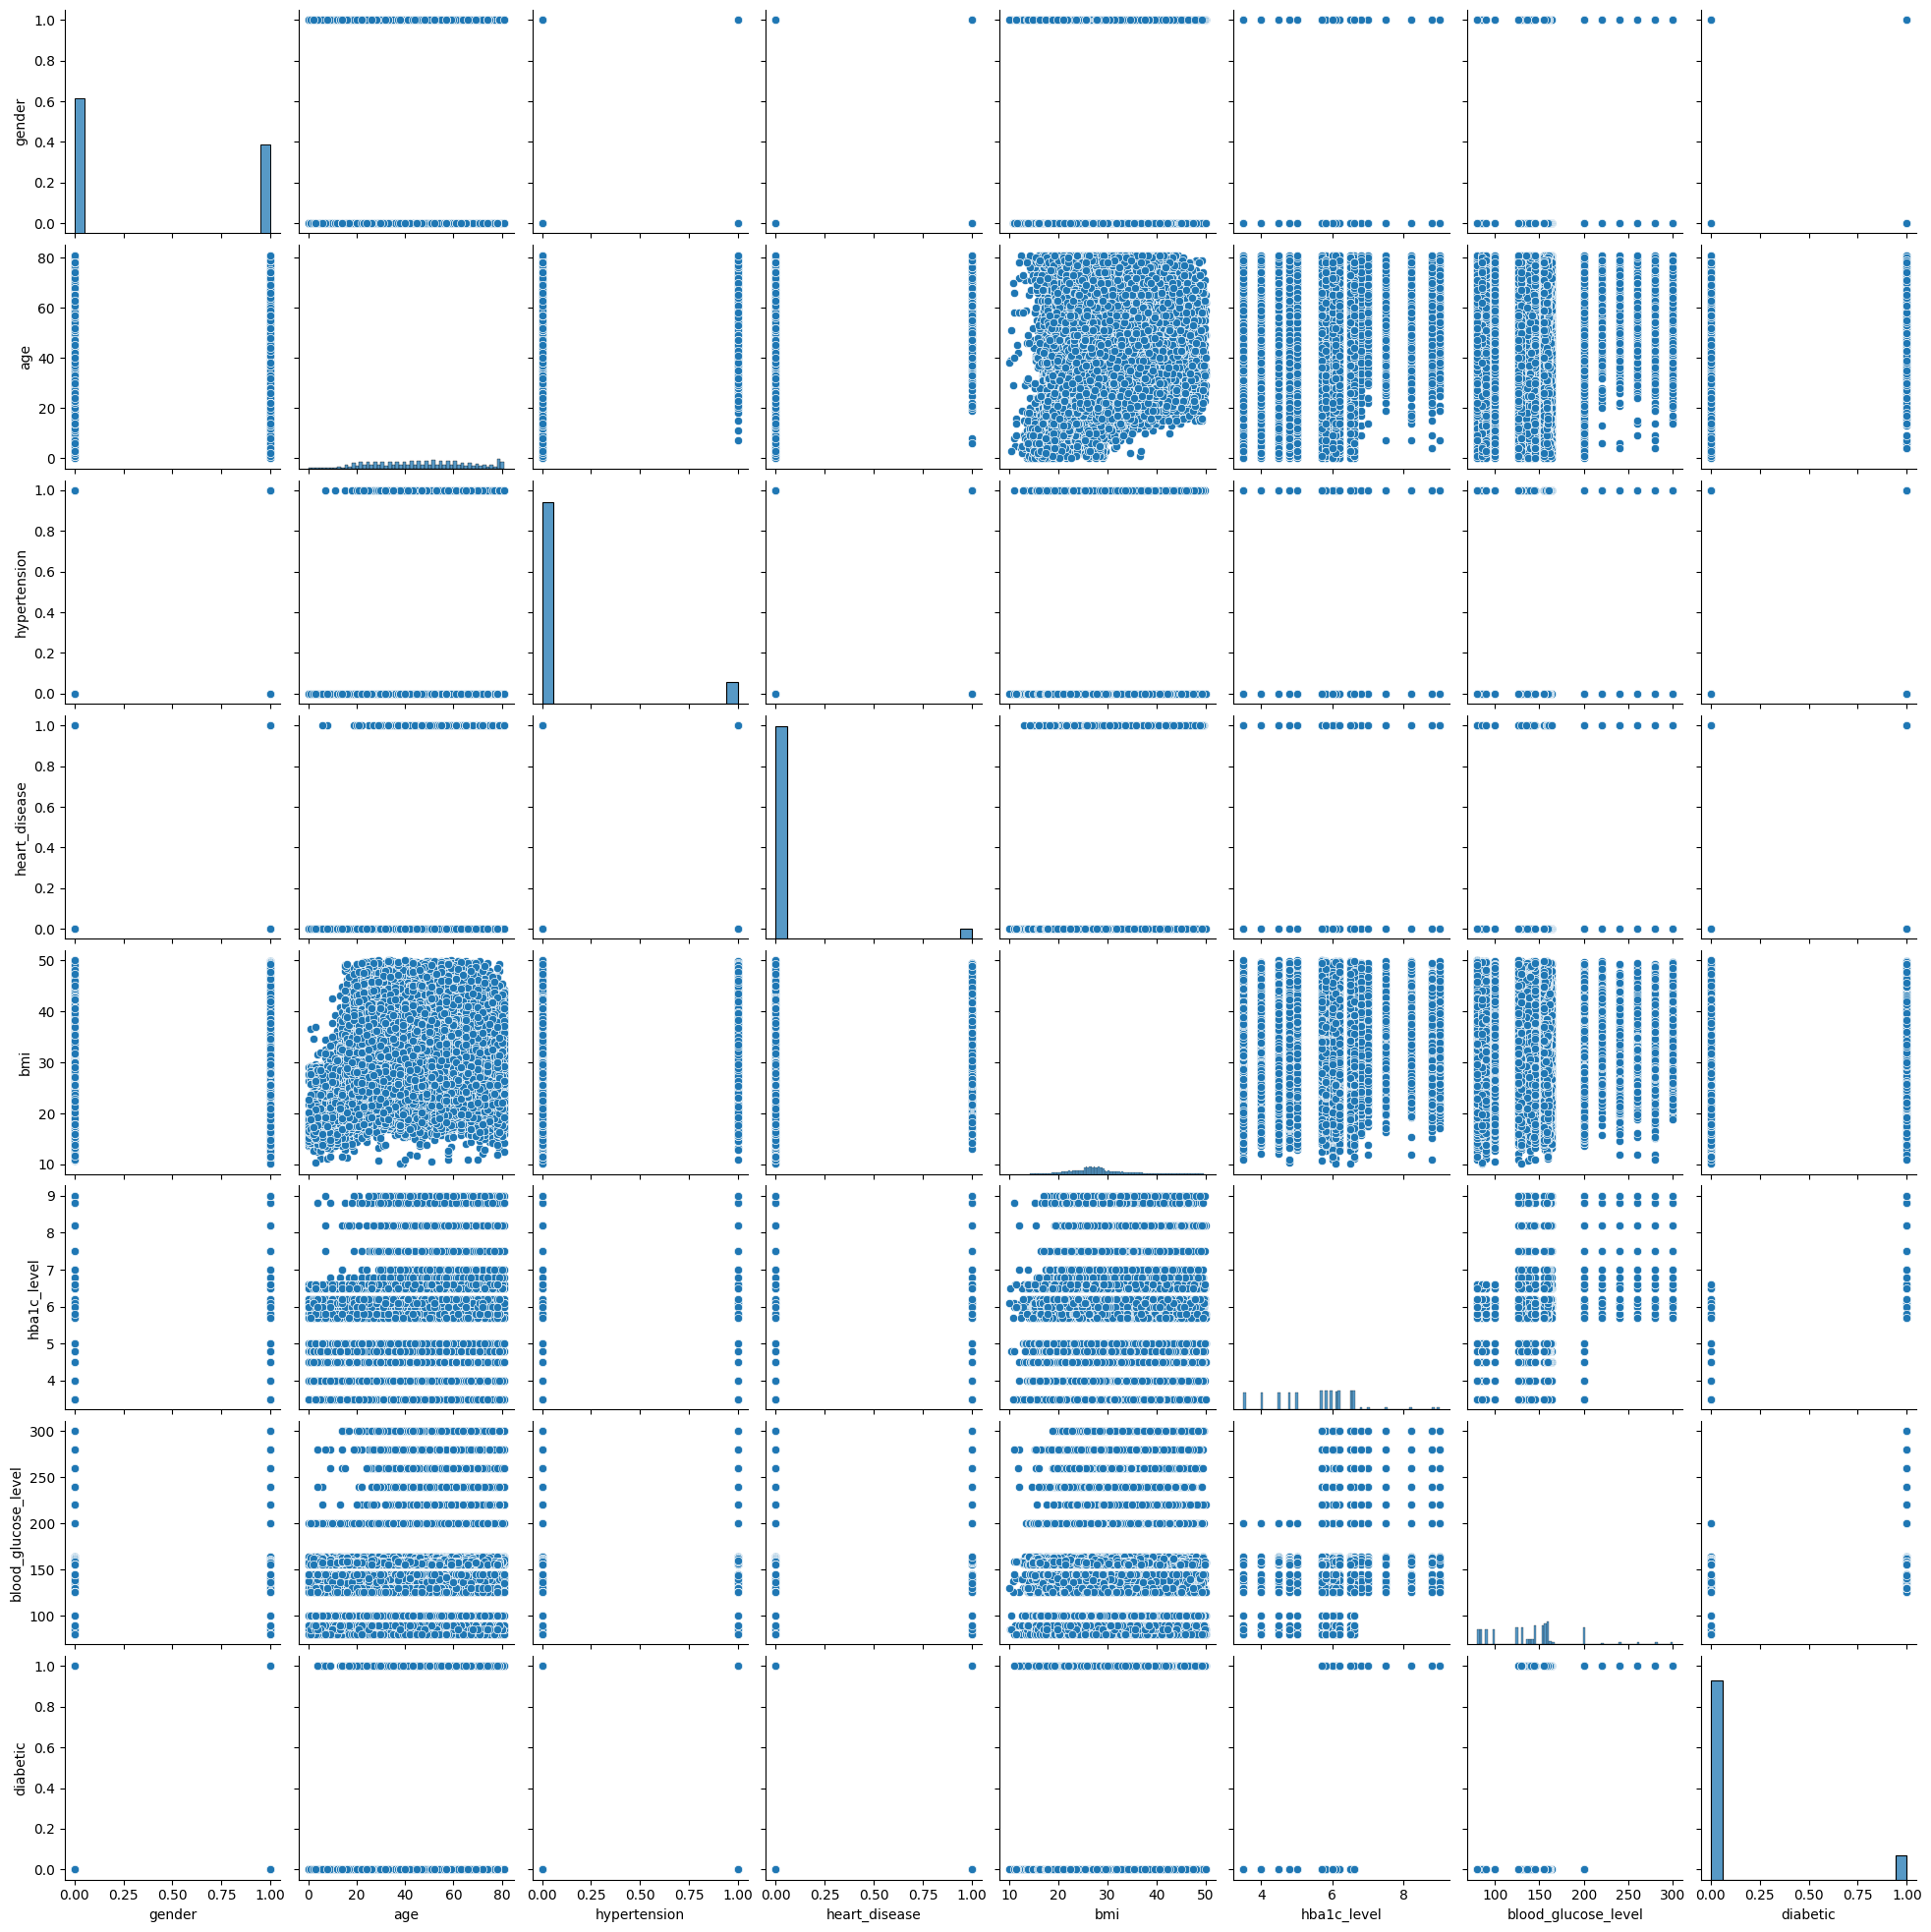

In [585]:
sns.pairplot(df_diabetes_eda)

#### Convertendo o "smoker" em numéricas

In [586]:
df_diabetes_eda.smoker = pd.factorize(df_diabetes_eda.smoker)[0] + 1
df_diabetes.smoker = pd.factorize(df_diabetes.smoker)[0] + 1

In [587]:
df_diabetes_eda.head(20)

,gender,age,hypertension,heart_disease,smoker,bmi,hba1c_level,blood_glucose_level,diabetic
0,0,78,0,1,1,25.19,6.6,140,0
2,1,28,0,0,1,26.66,5.7,158,0
3,0,36,0,0,2,23.45,5.0,155,0
4,1,76,1,1,2,20.14,4.8,155,0
5,0,20,0,0,1,27.43,6.6,85,0
6,0,44,0,0,1,19.31,6.5,200,1
8,1,42,0,0,1,33.64,4.8,145,0
9,0,32,0,0,1,25.97,5.0,100,0
10,0,53,0,0,1,28.84,6.1,85,0
12,0,78,0,0,3,36.05,5.0,130,0


#### Fazendo o mapa de calor

<Axes: >

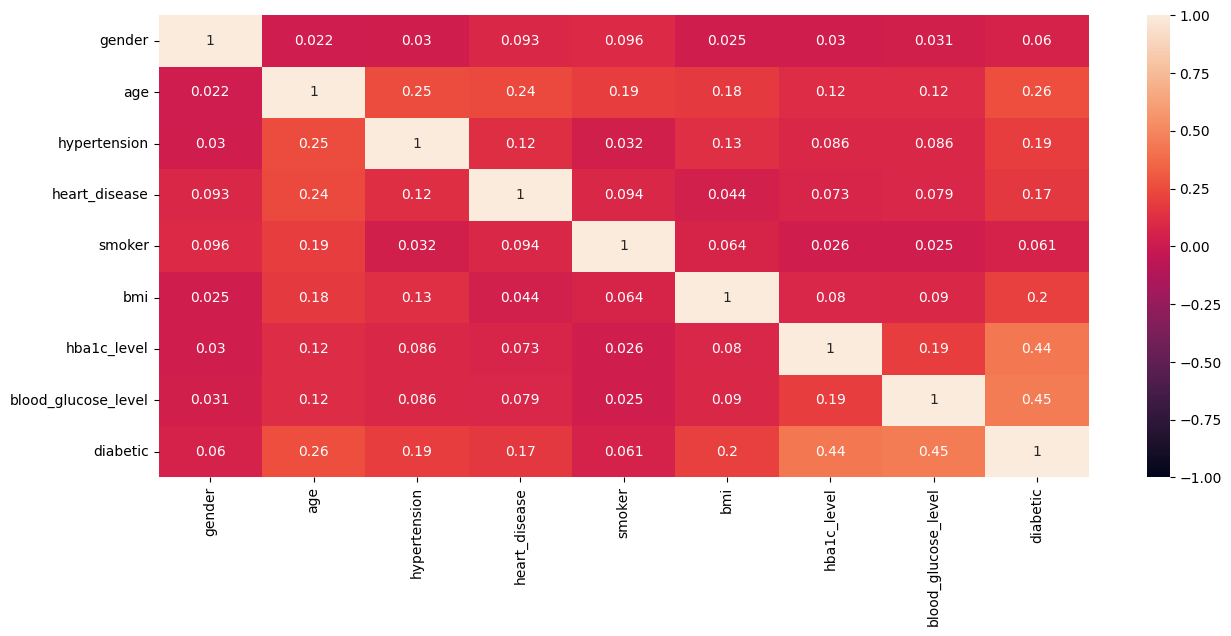

In [588]:
plt.figure(figsize=(15, 6))
sns.heatmap(df_diabetes_eda.corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

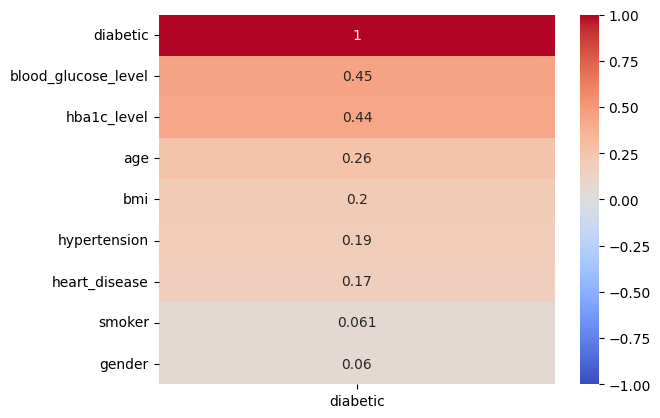

In [589]:
sns.heatmap(df_diabetes_eda.corr()[['diabetic']].sort_values(by='diabetic', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm', )

Depois de todas essas correlações, observamos que quanto maior o blood_glucose_level e hba1c_level, tendem a ter diabetes. E nenhuma variável tem correlação com a outra (fora diabetes).

## Separação dos dados

In [590]:
df_diabetes.drop(columns=['smoker'], axis=1, inplace=True)

In [591]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63563 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               63563 non-null  int64  
 1   age                  63563 non-null  int64  
 2   hypertension         63563 non-null  int64  
 3   heart_disease        63563 non-null  int64  
 4   bmi                  63563 non-null  float64
 5   hba1c_level          63563 non-null  float64
 6   blood_glucose_level  63563 non-null  int64  
 7   diabetic             63563 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 6.4 MB


### Definindo o X e y

In [592]:
X = df_diabetes.drop(columns=['diabetic'], axis=1)
y = df_diabetes['diabetic']

### Separação

In [593]:
# Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=51)

In [594]:
X_train.shape

(44494, 7)

In [595]:
X_test.shape

(19069, 7)

## Treinamento

### Criação do modelo

In [596]:
model_lr = LogisticRegression()

#Testar com outros solvers
# model_lr = LogisticRegression(solver='liblinear')

### Treinamento

In [597]:
model_lr.fit(X_train, y_train)

/home/rhogger/.local/share/virtualenvs/ia-NEqTXNFB/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

### Métricas do modelo base

In [598]:
y_pred = model_lr.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(19069,))

In [599]:
y_decision = model_lr.decision_function(X_test)
y_decision

array([-6.00035666, -8.36449851, -2.55252298, ..., -5.17192894,
       -6.43394878, -6.89082621], shape=(19069,))

In [600]:
y_prob = model_lr.predict_proba(X_test)
y_prob

array([[9.97528256e-01, 2.47174361e-03],
       [9.99767060e-01, 2.32939574e-04],
       [9.27742828e-01, 7.22571721e-02],
       ...,
       [9.94358394e-01, 5.64160592e-03],
       [9.98396479e-01, 1.60352077e-03],
       [9.98983960e-01, 1.01603979e-03]], shape=(19069, 2))

In [601]:
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9486601290051917


#### Curva ROC

In [602]:
fpr, tpr, thresholds = roc_curve(y_test, y_decision)

In [603]:
roc_auc = auc(fpr, tpr)
roc_auc

np.float64(0.9574364862141678)

In [604]:
fig = px.area(
  x=fpr, y=tpr,
  title=f'ROC Curve (AUC={roc_auc:.4f})',
  labels=dict(x='False Positive Rate', y='True Positive Rate'),
  width=700, height=500
)

fig.add_shape(
  type='line', line=dict(dash='dash'),
  x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

#### Importância das Features

In [605]:
importance = np.abs(model_lr.coef_)

In [606]:
print("Importância das Features")

for i, feature in enumerate(model_lr.feature_names_in_):
  print(f"{feature}: {importance[0][i]}")

Importância das Features
gender: 0.7213920377008336
age: 0.04630930898768027
hypertension: 0.48549661285469975
heart_disease: 1.0697173806653302
bmi: 0.09733790079573733
hba1c_level: 2.2064465380949203
blood_glucose_level: 0.03322379556850567


#### Calculando o f1_score

In [607]:
f1_score_baseline = f1_score(y_test, y_pred)
f1_score_baseline

0.7189204708584553

#### Apresentar BCE (Binary Cross Entropy)

In [608]:
log_loss(y_test, y_pred)

1.850476515178861

#### Apresentar a Matriz de Confusão

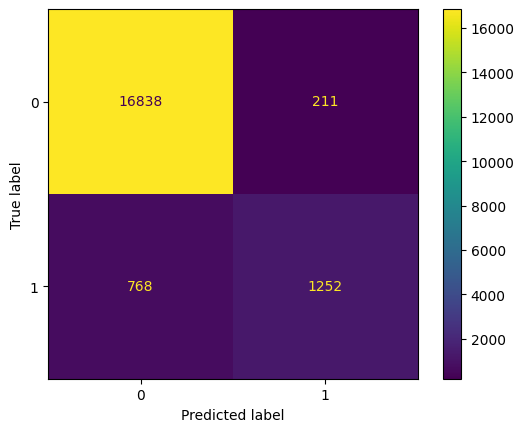

In [609]:
confusion_matrix_model = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix_model)
disp.plot()

Aqui notamos que a matrix de confusão pra prever se a pessoa tem diabetes, não está TÃO boa assim.

De 1478 casos em que a pessoa tem diabetes, ele errou 221 e em 17591 casos em que não tinha, 763 ele afirmou possuir diabates.

## Otimização de hiperparâmetros

### Ajuste de Hiperparâmetros

#### Penalty

Vamos fazer a regularização, controlando a complexidade do modelo e evitando overfitting.

Usaremos as regularizações:

- L1 (Ridge) - é útil para fins de Feature Selection(saber quais features ecolher pra uso do modelo) e para modelos esparsos (modelos com muitas variáveis e poucos valores), fazendo a soma absoluta dos coeficientes do modelo.
- L2 (Lasso) - é útil para evitar o overfitting, principalmente quando há multicolinearidade, somando o quadrado dos coeficientes.

#### C

Quando se há valores maiores deste hiperparâmetro, inidica que a regularização está fraca, e vice versa.

In [613]:
def lr_optuna(trial):
  penalty = trial.suggest_categorical('penalty', ['l2'])
  c_values = trial.suggest_categorical('c', [100, 10, 1.0, 0.1, 0.01])
  
  model_lr_optuna = LogisticRegression(penalty=penalty, C=c_values)
  model_lr_optuna.fit(X_train, y_train)
  
  y_decision_optuna = model_lr_optuna.decision_function(X_test)
  
  fpr, tpr, thresholds = roc_curve(y_test, y_decision_optuna)
  roc_auc = auc(fpr, tpr)
  
  y_pred_optuna = model_lr_optuna.predict(X_test)
  
  f1_score_optuna = f1_score(y_test, y_pred_optuna)
  
  log_loss_optuna = log_loss(y_test, y_pred_optuna)
  
  return roc_auc, f1_score_optuna, log_loss_optuna

#### Criação dos estudos

In [614]:
search_space = {'penalty': ['l2'], 'c': [100, 10, 1.0, 0.1, 0.01]}
sampler = optuna.samplers.GridSampler(search_space)
study_lr = optuna.create_study(directions=['maximize', 'maximize', 'minimize'])
study_lr.optimize(lr_optuna, n_trials=30)

[I 2025-03-02 23:02:57,506] A new study created in memory with name: no-name-687e5c82-8a65-4767-922e-b9a6c4dd7ab2
/home/rhogger/.local/share/virtualenvs/ia-NEqTXNFB/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[I 2025-03-02 23:02:57,634] Trial 0 finished with values: [0.9575832966016996, 0.7170464378425151, 1.8542568553528727] and parameters: {'penalty': 'l2', 'c': 10}.
/home/rhogger/.local/share/virtualenvs/ia-NEqTXNFB/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS 

In [615]:
best_trial = max(study_lr.best_trials, key=lambda t: t.values[1])
print('Trial com o melhor AUC e F! e menro BCE: ')
print('number: ', best_trial.number)
print('values: ', best_trial.values)
print('params: ', best_trial.params)

Trial com o melhor AUC e F! e menro BCE: 
number:  7
values:  [0.9578771787085448, 0.7198387561186295, 1.8391354946568248]
params:  {'penalty': 'l2', 'c': 100}


In [616]:
fig = optuna.visualization.plot_pareto_front(study_lr)
fig.show()

#### Comparação

In [617]:
print('AUC baseline: ', roc_auc)
print('AUC optuna: ', best_trial.values[0])

AUC baseline:  0.9574364862141678
AUC optuna:  0.9578771787085448


In [618]:
print('F1 Score baseline: ', f1_score_baseline)
print('F1 Score optuna: ', best_trial.values[1])

F1 Score baseline:  0.7189204708584553
F1 Score optuna:  0.7198387561186295


In [619]:
print('BCE baseline: ', log_loss(y_test, y_pred))
print('BCE optuna: ', best_trial.values[2])

BCE baseline:  1.850476515178861
BCE optuna:  1.8391354946568248


#### Teste com Thresholds diferentes

In [620]:
thresholds_list = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

results_list = {'cenarios': [], 'resultado': []}
results_list['cenarios'].append('baseline')
results_list['resultado'].append(f1_score_baseline)
results_list['cenarios'].append('optuna')
results_list['resultado'].append(best_trial.values[1])

for new_threshold in thresholds_list:
  y_pred_new_threshold = (model_lr.predict_proba(X_test)[:,1] >= new_threshold).astype(int)
  f1_score_new_threshold = f1_score(y_test, y_pred_new_threshold)
  
  results_list['cenarios'].append(str(new_threshold))
  results_list['resultado'].append(f1_score_new_threshold)

In [621]:
df_results = pd.DataFrame(results_list)

In [622]:
df_results

,cenarios,resultado
0,baseline,0.718920
1,optuna,0.719839
2,0.55,0.712563
3,0.6,0.703536
4,0.65,0.692665
5,0.7,0.681847
6,0.75,0.666019
7,0.8,0.643640
8,0.85,0.613598
9,0.9,0.568496


In [623]:
px.line(df_results, x='cenarios', y='resultado', title='F1 Score x Thresholds')

Vimos que quanto maior o threshold, pior o resultado.

## Salvar o modelo

In [628]:
joblib.dump(model_lr, '../models/model_diabetes.pkl')

['../models/model_diabetes.pkl']